<div>
<img src="https://drive.google.com/uc?export=view&id=1vK33e_EqaHgBHcbRV_m38hx6IkG0blK_" width="350"/>
</div> 

#**Artificial Intelligence - MSc**
##ET5003 - MACHINE LEARNING APPLICATIONS 

###Instructor: Enrique Naredo
###ET5003_KaggleCompetition

In [99]:
#@title Current Date
Today = '2021-10-05' #@param {type:"date"}


In [100]:
#@markdown ---
#@markdown ### Enter your details here:
Team_Number = "6" #@param {type:"string"}
Student_ID&Name = "9309888_JohnHayes" #@param {type:"string"}
Student_ID&Name = "" #@param {type:"string"}
Student_ID&Name = "" #@param {type:"string"}
Student_ID&Name = "" #@param {type:"string"}
Student_ID&Name = "" #@param {type:"string"}
#@markdown ---

SyntaxError: cannot assign to operator (876388139.py, line 4)

In [ ]:
#@title Notebook information
Notebook_type = 'Etivity' #@param ["Example", "Lab", "Practice", "Etivity", "Assignment", "Exam"]
Version = 'Final' #@param ["Draft", "Final"] {type:"raw"}
Submission = True #@param {type:"boolean"}

# INTRODUCTION

This etivity combines the techniques of NLP, Piecewise Regression and Bayesian Neural Networks in an attempt to predict house prices from a given data set. Each section is outlined below with any information for it detailed in each section.<br><br>
**Note:** It will create 3 files in the current directory - the purpose of these was to submit them to the Kaggle competition.

***The goal is to use advanced Machine Learning methods to predict House price.***

## Imports

In [101]:
# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")

In [102]:
# standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [103]:
# to plot
import matplotlib.colors
from mpl_toolkits.mplot3d import Axes3D

# to generate classification, regression and clustering datasets
import sklearn.datasets as dt

# to create data frames
from pandas import DataFrame

# to generate data from an existing dataset
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

In [104]:
# Scikit-learn is an open source machine learning library 
# that supports supervised and unsupervised learning
# https://scikit-learn.org/stable/
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.impute import SimpleImputer

In [105]:
# Regular expression operations
#https://docs.python.org/3/library/re.html
import re 

# Natural Language Toolkit
# https://www.nltk.org/install.html
import nltk

# Stemming maps different forms of the same word to a common “stem” 
# https://pypi.org/project/snowballstemmer/
from nltk.stem import SnowballStemmer

# https://www.nltk.org/book/ch02.html
from nltk.corpus import stopwords

# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture

# for plots etc
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer

# For NLP
import spacy as sp
from spacy import displacy

# For feature importance
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestRegressor

#from imblearn.combine import SMOTETomek

from collections import Counter

import datetime

In [106]:
!pip install gpy

Defaulting to user installation because normal site-packages is not writeable


In [107]:
import GPy as GPy
import numpy as np
import pylab as pb
import pymc3 as pm
import arviz as az

### Function definitions
#### Functions for NLP

In [108]:
#--------------------------------------------------------------------------------
def nlk_nlp_preprocess(text_feat,
                       stop_words,
                       df_data,
                       min_word_len):
    """
    Preprocessing training and test features
    """
    
    #print("Columns {}".format(df_data.columns))
    #print("Features '{}'".format(text_feat))
    for feat in text_feat:
        
        #print("Using feature '{}'".format(feat))
        data_list = df_data[feat].tolist()
        tmp_df = pd.DataFrame({feat:data_list})
        
        # Removing numbers and single letters from the dataset, except for what is     
        tmp_df[feat] = tmp_df[feat].str.replace("[^a-zA-Z#]", " ")
    
        # Removing single letters
        tmp_df[feat] = tmp_df[feat].apply(lambda x: ' '.join([w for w in x.split() if len(w)>1]))
        
        # Remove short words
        tmp_df[feat] = tmp_df[feat].apply(lambda x: ' '.join([w for w in x.split() if len(w)>min_word_len]))
    
        # Make all text lower case
        tmp_df[feat] = tmp_df[feat].apply(lambda x: x.lower())
    
        # Tokenisation
        tokenised_doc = tmp_df[feat].apply(lambda x: x.split())

        # remove stop-words
        tokenised_doc = tokenised_doc.apply(lambda x: [item for item in x if item not in stop_words])
        
        print("Len of feat {}".format(len(df_data[feat])))

        # de-tokenization
        detokenised_doc = []
        for i in range(len(df_data[feat])):
            t = ' '.join(tokenised_doc[i])
            detokenised_doc.append(t)

        # Replace feature with the de-tokenised text
        df_data[feat] = detokenised_doc
        
        data_list = []

    return df_data

#--------------------------------------------------------------------------------
def nlp_train(xtrain_data, y_data, split=0.25):
    """
    Calculate training and prediction for specific NLP attributes.
    """

    X_train, X_test, y_train, y_test = train_test_split(xtrain_data,
                                                        y_data,
                                                        test_size=split)
    # create a model
    MNB_loc = MultinomialNB()

    # fit to data
    MNB_loc.fit(X_train, y_train)

    # Testing the model
    y_pred_train = MNB_loc.predict(X_train)
    #print('Location training prediction\t', y_pred_train)

    y_pred_test = MNB_loc.predict(X_test)
    #print('Location test prediction\t', y_pred_test)
    
    return y_train, y_test, y_pred_train, y_pred_test


#### Functions for Piecewise

In [109]:

def run_model(x_data, y_data, iterations, sample_size, text=None):
    """
    Execute the model for a given data set
    """
    
    if text != None:
        print(text)
    
    with pm.Model() as model:
        
        # prior over the parameters of linear regression
        alpha = pm.Normal('alpha', mu=0, sigma=30)
  
        # we have a beta for each column of Xn0
        beta = pm.Normal('beta', mu=0, sigma=30, shape=x_data.shape[1])
  
        # prior over the variance of the noise
        sigma = pm.HalfCauchy('sigma_n', 5)
  
        # linear regression relationship
        # linear regression model in matrix form
        mu = alpha + pm.math.dot(beta, x_data.T)
        
        # likelihood, be sure that observed is a 1d vector
        like = pm.Normal('like', mu=mu, sigma=sigma, observed=y_data[:,0])
        
    with model:
        
        # iterations of the algorithm
        approximation = pm.fit(iterations,method='advi')

    # samples from the posterior   
    posterior = approximation.sample(sample_size)
    
    return posterior, approximation


#--------------------------------------------------------------------------------
def ppc(alpha, beta, sigma, X, nsamples=500):
    """
    Posterior predictive checks (PPCs)
    """
    
    # Select nsamples random samples from the posterior
    ind = np.random.randint(0,beta.shape[0],size=nsamples)
    alphai = alpha[ind]
    betai = beta[ind,:]
    sigmai = sigma[ind]

    Ypred = np.zeros((nsamples,X.shape[0]))
    for i in range(X.shape[0]):
        
        # we generate data from linear model
        y_pred = alphai + np.dot(betai, X[i:i+1,:].T).T + \
                                    np.random.randn(len(sigmai))*sigmai
        Ypred[:,i]=y_pred[0,:]
        
    return Ypred


#--------------------------------------------------------------------------------
def train_cluster(x_train, x_test, y_train, clust_num):
    """
    Train the cluster
    """
    
    Xn = x_train[clusters_train==clust_num,:]
    Xtestn = x_test[clusters_test==clust_num,:]

    ylog = np.log(y_train.astype('float')[clusters_train==clust_num,:])
    yscaler = StandardScaler().fit(ylog)
    yn = yscaler.transform(ylog)
    
    return ylog, Xn, yn, Xtestn, yscaler


#--------------------------------------------------------------------------------
def plot_redictions(y_pred, ylog, title=None):
    
    plt.figure(figsize=(9,8))
    for i in range(y_pred.shape[0]):
        az.plot_dist( y_pred[i,:],color='r',plot_kwargs={"linewidth": 0.2})
        
    az.plot_dist(y_pred[i,:],color='r',
                 plot_kwargs={"linewidth": 0.2},
                 label="prediction")
    
    az.plot_dist(ylog, label='true observations');
    if title != None:
        plt.title(title)
        
    plt.legend()
    plt.xlabel("log(y) - output variable")
    plt.ylabel("density plot");


#--------------------------------------------------------------------------------
def cluster_sim(posterior, Xn, ylog, title=None, num_samples=200):
    """
    Display a prediction for a single cluster
    """
    
    # Simulation
    Ypred = yscaler.inverse_transform(ppc(posterior['alpha'],
                                            posterior['beta'],
                                            posterior['sigma_n'],
                                            Xn,
                                            nsamples=num_samples))
    plot_redictions(Ypred, ylog, title)
    

#--------------------------------------------------------------------------------
def create_heat_map(data):
    """
    Create a correlation matrix
    """
    
    # Plot the heatmap. The numbers are easier to read IMO
    corr = data.corr()
    fig, ax = plt.subplots(figsize=(12,12))
    sns.heatmap(corr,
            xticklabels=corr.columns,
            yticklabels=corr.columns,
            annot=True,
            cmap=sns.diverging_palette(220, 20, as_cmap=True),
            ax=ax)
    

In [110]:
print("Start time {}".format(datetime.datetime.now().time()))

Start time 19:03:44.426388


#### Some variables that will be used throughout

In [111]:
# Define the seed so that results can be reproduced
seed = 11
rand_state = 11

num_iter = 50000
sample_size = 5000
num_of_clust_samples = 200

# Define the color maps for plots
color_map = plt.cm.get_cmap('RdYlBu')
color_map_discrete = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","cyan","magenta","blue"])

train_test_percent = 0.35

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/johnh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# DATASET

Extract from this [paper](https://ieeexplore.ieee.org/document/9300074):

* House prices are a significant impression of the economy, and its value ranges are of great concerns for the clients and property dealers. 

* Housing price escalate every year that eventually reinforced the need of strategy or technique that could predict house prices in future. 

* There are certain factors that influence house prices including physical conditions, locations, number of bedrooms and others.


1. [Download the dataset](https://github.com/UL-CS6134/CS6134_SEM1_2021-2/tree/main/Week-5). 

2. Upload the dataset into your folder.



The challenge is to predict the final price of each house.

## Training & Test Data

#### Load the data

In [112]:
RunningInCOLAB = 'google.colab' in str(get_ipython())

if RunningInCOLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    
    # Path, copy the path from your Drive
    Path = '/content/drive/MyDrive/Colab Notebooks/Etivity3-Data/'
    
else:
    Path = "./"
    
# House price data from csv files
train_data = Path + 'HousePrice_Train.csv'
test_data = Path + 'HousePrice_Test.csv'

df_train_data = pd.read_csv(train_data)
print("Training data {}".format(df_train_data.shape))

# Test data
df_test_data = pd.read_csv(test_data)
print("Test data {}".format(df_test_data.shape))

Training data (1638, 14)
Test data (702, 13)


### Train dataset

In [113]:
# show first data frame rows 
df_train_data.head()

,Index,ID,Location,Num_Bathrooms,Num_Beds,BER_class,Description,Services,Features,Latitude,Longitude,Type,Surface,Price
0,1,12409116,Ongar,2,2,C3,DNG are delighted to present to the market no....,NaN,None,53.396659,-6.438791,apartment,67.00,195000
1,2,12320330,North Strand,1,2,D1,13 Northbrook Terrace is a charming red brick ...,NaN,Bight and Spacious interior\nNumerous original...,53.357129,-6.239779,terraced,95.97,425000
2,3,12405953,Stepaside,3,3,A3,"Welcome to No. 6 Cotter Close, an immaculately...",NaN,Special Features\nLarge rear garden\nGenerous ...,53.266468,-6.222771,semi-detached,107.00,535000
3,4,12202582,Cabinteely,1,3,E1,Welcome to 3 Sycamore Walk!\n\r\nEnjoying a pr...,NaN,Wonderful 3 bed detached bungalow. \nAccom...,53.261600,-6.166738,detached,81.00,499000
4,5,12299336,Lusk,3,4,D1,'Four Seasons' comes to the market as a wonder...,NaN,Detached Property \nDouble Glazed Windows...,53.550731,-6.121415,detached,153.00,510000


In [114]:
# Generate descriptive statistics
df_train_data.describe(include='all')

,Index,ID,Location,Num_Bathrooms,Num_Beds,BER_class,Description,Services,Features,Latitude,Longitude,Type,Surface,Price
count,1638.000000,1.638000e+03,1638,1638.000000,1638.000000,1387,1638,577,1638,1638.000000,1638.000000,1638,1638.000000,1.638000e+03
unique,NaN,NaN,142,NaN,NaN,16,1638,31,1118,NaN,NaN,10,NaN,NaN
top,NaN,NaN,Castleknock,NaN,NaN,D1,DNG are delighted to present to the market no....,"Parking,Gas Fired Central Heating",None,NaN,NaN,semi-detached,NaN,NaN
freq,NaN,NaN,57,NaN,NaN,182,1,118,516,NaN,NaN,458,NaN,NaN
mean,819.500000,1.231930e+07,NaN,2.054335,3.043346,NaN,NaN,NaN,NaN,53.350473,-6.255086,NaN,169.540695,5.547196e+05
std,472.994186,1.447540e+05,NaN,1.241259,1.379650,NaN,NaN,NaN,NaN,0.076832,0.144430,NaN,1791.793934,5.652032e+05
min,1.000000,1.118567e+07,NaN,1.000000,1.000000,NaN,NaN,NaN,NaN,52.501856,-6.497000,NaN,3.400000,1.999500e+04
25%,410.250000,1.228104e+07,NaN,1.000000,2.000000,NaN,NaN,NaN,NaN,53.294261,-6.309613,NaN,73.000000,2.950000e+05
50%,819.500000,1.238055e+07,NaN,2.000000,3.000000,NaN,NaN,NaN,NaN,53.341386,-6.247780,NaN,97.050000,3.950000e+05
75%,1228.750000,1.240548e+07,NaN,3.000000,4.000000,NaN,NaN,NaN,NaN,53.382031,-6.193982,NaN,135.000000,5.950000e+05


So there are 1638 entries. Both `BER_class` and `Services` have less than that. The `Services` is missing a lot of entries.

In [115]:
# Check for missing values
df_train_data.isna().sum()

Index               0
ID                  0
Location            0
Num_Bathrooms       0
Num_Beds            0
BER_class         251
Description         0
Services         1061
Features            0
Latitude            0
Longitude           0
Type                0
Surface             0
Price               0
dtype: int64

Since `Services` is missing over 60% of entries and there is no reasonable way to fill in values for that feature, given what it is used for, I think it should be dropped from the evaluation.

In [116]:
df_train_data['BER_class'].value_counts()

D1                     182
D2                     173
C3                     154
C2                     144
C1                     133
E1                     110
G                      103
E2                     101
F                       89
B3                      78
B2                      48
A3                      37
SINo666of2006exempt     15
A2                      12
B1                       7
A1                       1
Name: BER_class, dtype: int64

In [117]:
df_train_data['Num_Beds'].value_counts()

3     558
2     464
4     348
1     114
5     107
6      29
7      11
9       2
15      2
8       2
27      1
Name: Num_Beds, dtype: int64

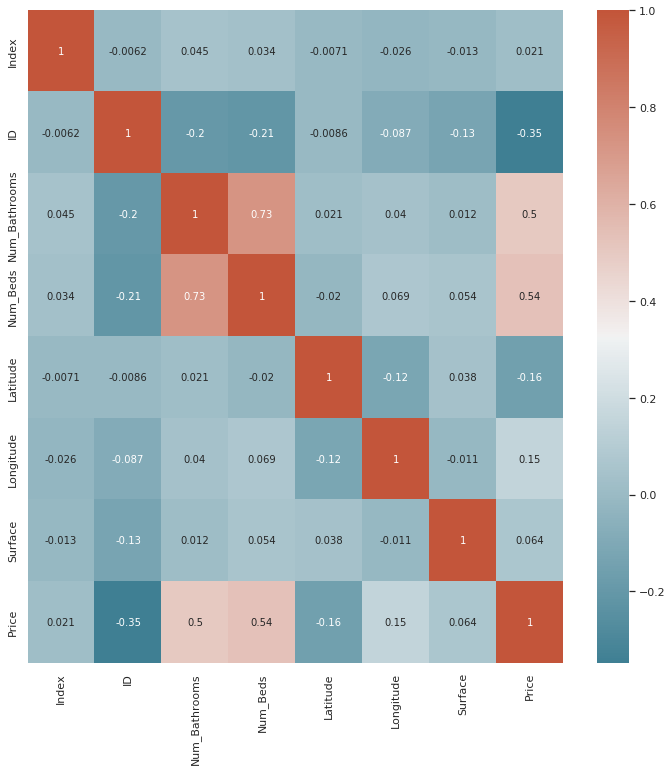

In [118]:
create_heat_map(df_train_data)

The above is showing little correlation between the various features, with the only significant ones being the number of `Num_Beds` and `Num_Bathrooms` related to `price`.

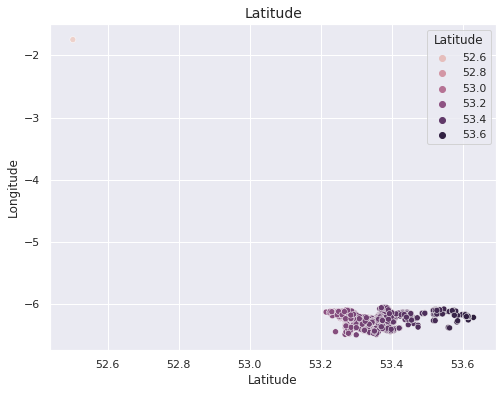

In [119]:
sns.set(rc={'figure.figsize':(8,6)})

sns.scatterplot(data=df_train_data,x='Latitude', y='Longitude', hue='Latitude')
plt.title("Latitude", fontsize=14)
plt.show()

The above is showing 1 outlier. It is in row 357 with lonitude of -1.744995 latitude of 52.5018563. This is showing as 34-12 Wheatfield Cl, Birmingham B36 0QP, UK, so I will drop this value.

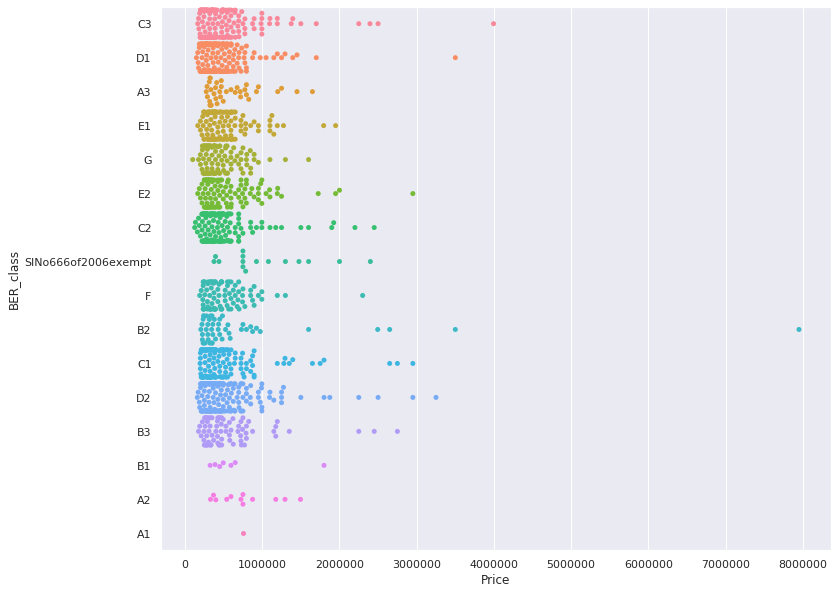

In [120]:
sns.set(rc={'figure.figsize':(12, 10)})
sns.swarmplot(data=df_train_data, x='Price', y='BER_class')
plt.show()

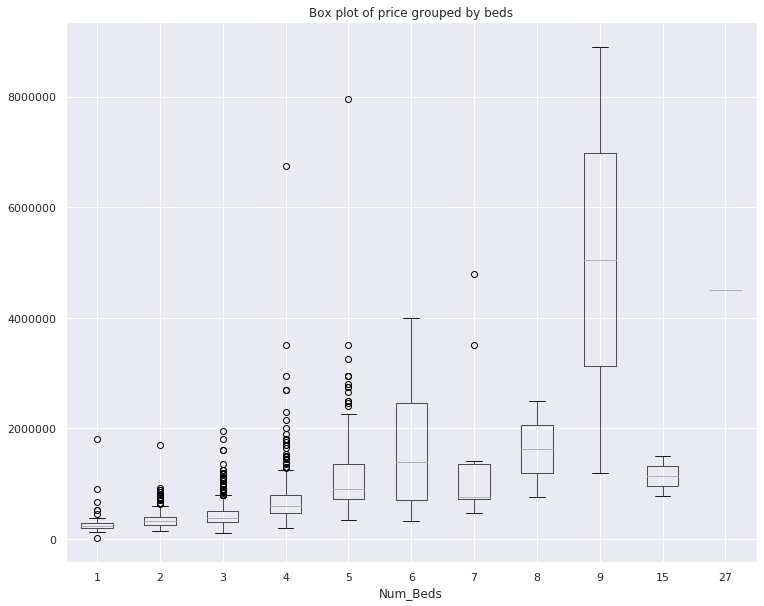

In [121]:
df_train_data.boxplot(column='Price', by='Num_Beds')
plt.title('Box plot of price grouped by beds')
plt.suptitle("")
plt.show()

### Test dataset

In [122]:
# show first data frame rows 
df_test_data.head()

,Index,ID,Location,Num_Bathrooms,Num_Beds,BER_class,Description,Services,Features,Latitude,Longitude,Type,Surface
0,1639,12292473,Milltown,2,2,C2,OMD Estate Agents are delighted to present thi...,"Parking,Oil Fired Central Heating",Designated parking spaces\nPresented in pristi...,53.316269,-6.243391,townhouse,65.0
1,1640,12314667,Glasnevin,2,5,E1,Welcome to Saint Anthony No.214 Glasnevin Aven...,"Parking,Gas Fired Central Heating",Modern Worcester Gas Boiler\nSingle Glazed Win...,53.390769,-6.281936,semi-detached,142.0
2,1641,11699240,Dalkey,1,2,G,"Located in this ever popular road, on grounds ...",NaN,2 BEDROOM DETACHED HOUSE ON 1/5th ACRE\nOIL F...,53.272486,-6.108675,detached,80.0
3,1642,12416984,Raheny,4,4,A2,DNG are delighted to represent the sale of thi...,"Parking,Alarm",Detached House\nSouth Facing Garden\nOff Stree...,53.376932,-6.185334,detached,209.0
4,1643,12383407,Crumlin,2,3,F,A unique opportunity to acquire this red brick...,"Parking,Gas Fired Central Heating,Alarm",Red brick end of terrace property \nC. 108sqm ...,53.327208,-6.308938,end-of-terrace,108.0


In [123]:
# Generate descriptive statistics
df_test_data.describe(include='all')

,Index,ID,Location,Num_Bathrooms,Num_Beds,BER_class,Description,Services,Features,Latitude,Longitude,Type,Surface
count,702.000000,7.020000e+02,702,702.000000,702.000000,594,702,246,702,702.000000,702.000000,702,702.000000
unique,NaN,NaN,129,NaN,NaN,15,702,27,506,NaN,NaN,9,NaN
top,NaN,NaN,Rathfarnham,NaN,NaN,D1,OMD Estate Agents are delighted to present thi...,"Parking,Gas Fired Central Heating",None,NaN,NaN,apartment,NaN
freq,NaN,NaN,28,NaN,NaN,72,1,51,197,NaN,NaN,194,NaN
mean,1989.500000,1.231545e+07,NaN,2.027066,2.987179,NaN,NaN,NaN,NaN,53.350445,-6.252411,NaN,132.603530
std,202.794231,1.420680e+05,NaN,1.071273,1.198480,NaN,NaN,NaN,NaN,0.073961,0.091600,NaN,330.347066
min,1639.000000,1.147889e+07,NaN,1.000000,1.000000,NaN,NaN,NaN,NaN,53.214227,-6.521183,NaN,32.100000
25%,1814.250000,1.227637e+07,NaN,1.000000,2.000000,NaN,NaN,NaN,NaN,53.295225,-6.304258,NaN,73.000000
50%,1989.500000,1.237928e+07,NaN,2.000000,3.000000,NaN,NaN,NaN,NaN,53.341153,-6.247799,NaN,99.200000
75%,2164.750000,1.240421e+07,NaN,3.000000,4.000000,NaN,NaN,NaN,NaN,53.381751,-6.184277,NaN,136.875000


In [124]:
# Check for missing values
df_test_data.isna().sum()

Index              0
ID                 0
Location           0
Num_Bathrooms      0
Num_Beds           0
BER_class        108
Description        0
Services         456
Features           0
Latitude           0
Longitude          0
Type               0
Surface            0
dtype: int64

As with the training data, since `Services` is missing over 50% of entries and there is no reasonable way to fill in values for that feature, given what it is used for, I think it should be dropped from the evaluation.

In [125]:
df_test_data['BER_class'].value_counts()

D1                     72
C3                     70
D2                     68
C2                     65
C1                     49
E2                     47
F                      46
E1                     44
G                      41
B3                     28
B2                     21
A3                     20
A2                      8
SINo666of2006exempt     8
B1                      7
Name: BER_class, dtype: int64

### Data Preparation <a id='data_preparation'></a>
* Remove anything with more than 6 beds and those that have no number specified.
* Remove anything with no `Num_Bathroom` value set.
* Remove `Services` since there are so many values missing.
* Remove the invalid long & lat entry.
* Apply some NLP examination to `Description`, `Features` and `Type` attributes.
* `BER_Class` is useful and there are less than 16% from the training set missing so I will impute the values. Leaving it out also means reducting the training size to less than 702 (for the Kaggle entry).

In [126]:
df_train_clean = df_train_data.drop(columns=['Services', 'ID'])
df_test_clean = df_test_data.drop(columns=['Services', 'ID'])
print(df_test_clean.shape)

# The Longitude & latitude outlier from above
df_train_clean = df_train_clean.drop(df_train_clean[(df_train_clean.Longitude > -5) |
                                              (df_train_clean.Latitude < 52)].index)

(702, 11)


Look again at the spread of houses with the longitude and latitude outlier removed.

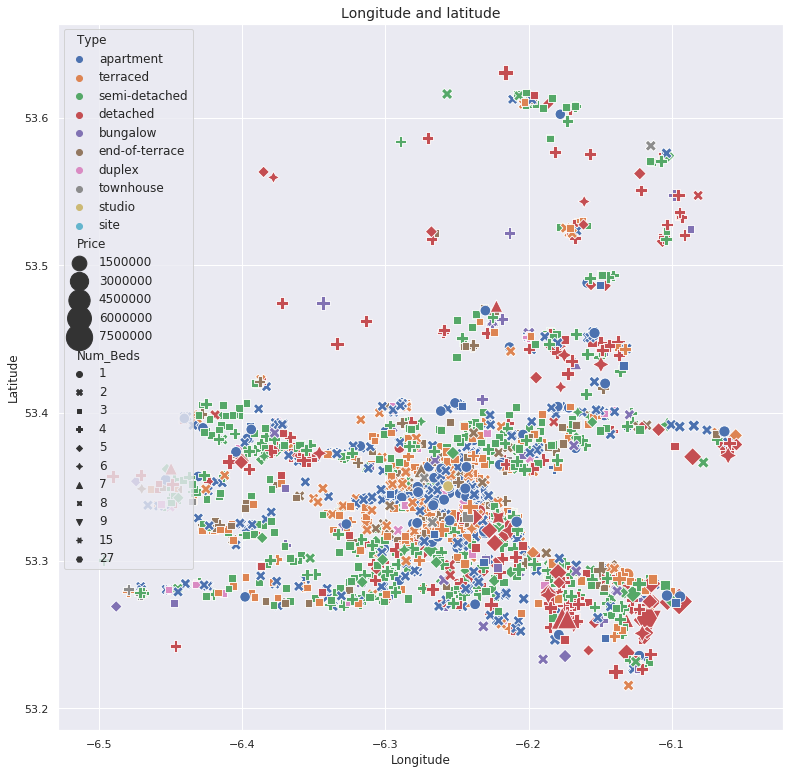

In [127]:
sns.set(rc={'figure.figsize':(13,13)})

sns.scatterplot(data=df_train_clean,
                x='Longitude',
                y='Latitude',
                style='Num_Beds',
                size="Price",
                hue="Type",
                sizes=(100, 800))

plt.title("Longitude and latitude", fontsize=14)
plt.show()

#### Continue with the preperation <a id='continue_cleaning'></a>
Convert `BER_class` into numerical formats. I think the increasing number in `BER_class` is justified as that what the classification is - I.E an increasing number means it uses more energy. I am using a simple imputer as the multivariate was listed as experimental on https://scikit-learn.org/stable/modules/impute.html.

Must convert the categorical values to integers before imputing.

In [128]:
print(df_train_clean.shape)
ber_features = df_train_clean['BER_class'].sort_values().unique()

new_ber_values = np.arange(1, len(ber_features) + 1).tolist()

df_train_clean['BER_class'].replace(to_replace=ber_features,
                                      value=new_ber_values,
                                      inplace=True)
df_train_clean['BER_class'].value_counts()

(1637, 12)


17    250
10    182
11    173
9     154
8     144
7     133
12    110
15    103
13    101
14     89
6      78
5      48
3      37
16     15
2      12
4       7
1       1
Name: BER_class, dtype: int64

In [129]:
imp_mean = SimpleImputer(strategy='mean')
imputed_train_ber = imp_mean.fit_transform(df_train_clean['BER_class'].values.reshape(-1,1))
df_train_clean['BER_class'] = imputed_train_ber
print(imputed_train_ber.shape)

(1637, 1)


Now check the `BER_class` after the changes.

In [130]:
df_train_clean.isna().sum()

Index            0
Location         0
Num_Bathrooms    0
Num_Beds         0
BER_class        0
Description      0
Features         0
Latitude         0
Longitude        0
Type             0
Surface          0
Price            0
dtype: int64

In [131]:
df_train_clean['BER_class'].value_counts()

17.0    250
10.0    182
11.0    173
9.0     154
8.0     144
7.0     133
12.0    110
15.0    103
13.0    101
14.0     89
6.0      78
5.0      48
3.0      37
16.0     15
2.0      12
4.0       7
1.0       1
Name: BER_class, dtype: int64

Replace the missing `BER_Class` values from the test data.

In [132]:
df_test_clean['BER_class'].replace(to_replace=ber_features,
                                      value=new_ber_values,
                                      inplace=True)

df_test_clean['BER_class'].value_counts()

17    108
10     72
9      70
11     68
8      65
7      49
13     47
14     46
12     44
15     41
6      28
5      21
3      20
2       8
16      8
4       7
Name: BER_class, dtype: int64

In [133]:
imputed_test_ber = imp_mean.fit_transform(df_test_clean['BER_class'].values.reshape(-1,1))
df_test_clean['BER_class'] = imputed_test_ber

print(imputed_test_ber.shape)
print(df_test_clean.shape)


(702, 1)
(702, 11)


In [134]:
# Replace property type
replace_ptype_features = ['apartment', 'studio', 'duplex', 'townhouse', 'terraced', 'end-of-terrace',
                          'semi-detached', 'detached', 'bungalow', 'site' ]

replace_values = np.arange(1, len(replace_ptype_features) + 1).tolist()

# Apply basic conversion to the property type
df_train_clean['Type'].replace(to_replace=replace_ptype_features,
                                      value=replace_values,
                                      inplace=True)

df_test_clean['Type'].replace(to_replace=replace_ptype_features,
                                      value=replace_values,
                                      inplace=True)
                
# Remove columns with 0 - causes problems for the scalers used below
df_train_new = df_train_clean[(df_train_clean.Num_Beds>0)]

# Also drops all sites - this is intended
df_train_new = df_train_clean[(df_train_clean.Num_Bathrooms>0)]

df_train_new = df_train_clean[(df_train_clean.Price>0)]

#### Look again at the cleaned data.

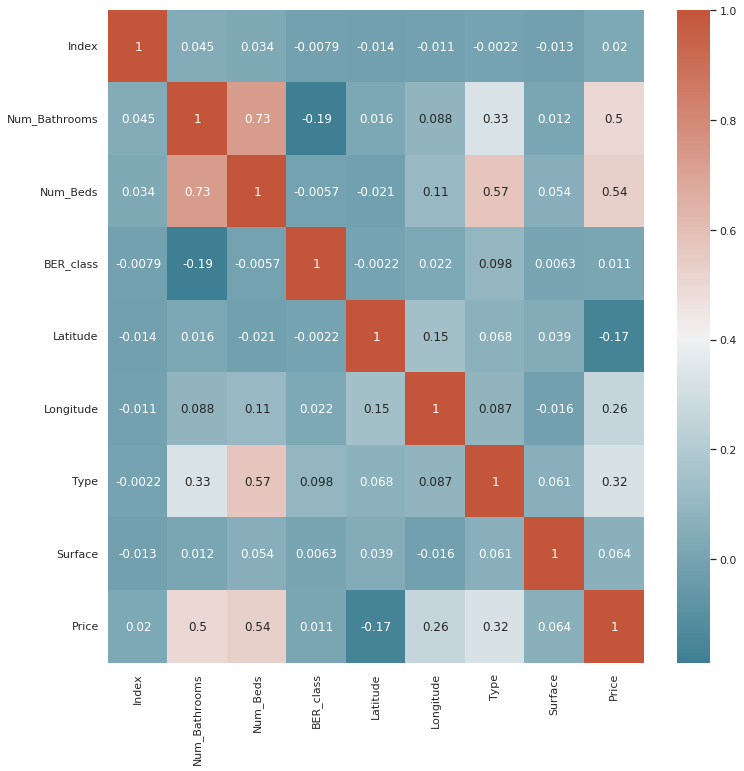

In [135]:
create_heat_map(df_train_clean)

In [136]:
print("Cleaned training missing values")
df_train_clean.isna().sum()

Cleaned training missing values


Index            0
Location         0
Num_Bathrooms    0
Num_Beds         0
BER_class        0
Description      0
Features         0
Latitude         0
Longitude        0
Type             0
Surface          0
Price            0
dtype: int64

In [137]:
df_train_clean.describe(include='all')

,Index,Location,Num_Bathrooms,Num_Beds,BER_class,Description,Features,Latitude,Longitude,Type,Surface,Price
count,1637.000000,1637,1637.000000,1637.000000,1637.000000,1637,1637,1637.000000,1637.000000,1637.000000,1637.000000,1.637000e+03
unique,NaN,142,NaN,NaN,NaN,1637,1118,NaN,NaN,NaN,NaN,NaN
top,NaN,Castleknock,NaN,NaN,NaN,DNG are delighted to present to the market no....,None,NaN,NaN,NaN,NaN,NaN
freq,NaN,57,NaN,NaN,NaN,1,515,NaN,NaN,NaN,NaN,NaN
mean,819.783140,NaN,2.054979,3.043372,10.982285,NaN,NaN,53.350991,-6.257841,5.073916,169.596004,5.549369e+05
std,472.999846,NaN,1.241364,1.380071,3.831768,NaN,NaN,0.073934,0.091825,2.696559,1792.340066,5.653074e+05
min,1.000000,NaN,1.000000,1.000000,1.000000,NaN,NaN,53.215381,-6.497000,1.000000,3.400000,1.999500e+04
25%,411.000000,NaN,1.000000,2.000000,8.000000,NaN,NaN,53.294340,-6.309640,1.000000,73.000000,2.950000e+05
50%,820.000000,NaN,2.000000,3.000000,11.000000,NaN,NaN,53.341510,-6.247821,6.000000,97.100000,3.950000e+05
75%,1229.000000,NaN,3.000000,4.000000,14.000000,NaN,NaN,53.382053,-6.194319,7.000000,135.000000,5.950000e+05


In [138]:
print("Cleaned testing missing values")
df_test_clean.isna().sum()

Cleaned testing missing values


Index            0
Location         0
Num_Bathrooms    0
Num_Beds         0
BER_class        0
Description      0
Features         0
Latitude         0
Longitude        0
Type             0
Surface          0
dtype: int64

Index(['Index', 'Location', 'Num_Bathrooms', 'Num_Beds', 'BER_class',
       'Description', 'Features', 'Latitude', 'Longitude', 'Type', 'Surface',
       'Price'],
      dtype='object')


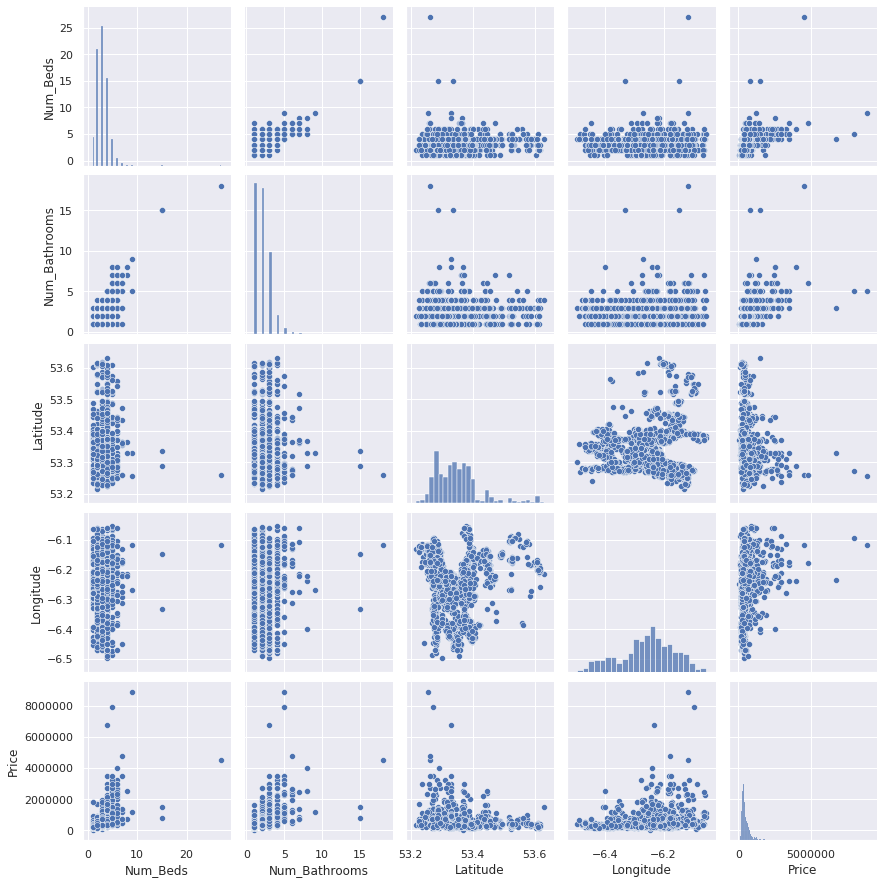

In [139]:
print(df_train_clean.columns)
sns.pairplot(data=df_train_clean[['Num_Beds','Num_Bathrooms', 'Latitude', 'Longitude', 'Price']])

# NATURAL LANGUAGE PROCESSING <a id='nlp_processing'></a>

Natural language processing ([NLP](https://en.wikipedia.org/wiki/Natural_language_processing)) is a subfield of linguistics, computer science, and artificial intelligence.

* NLP concerned with the interactions between computers and human language.
* In particular how to program computers to process and analyze large amounts of natural language data. 
* The goal is a computer capable of "understanding" the contents of documents.
* Including the contextual nuances of the language within them. 
* The technology can then accurately extract information and insights contained in the documents.
* As well as categorize and organize the documents themselves. 

Now apply some NLP examination to the `Location`, `Description` and `Features` attributes.

* Clean up the text data by:
    * Remove words less than 4 in length (the, as etc). They are too common and probably don't add value
    * Convert all to lowercase
* Then tokenise the data - split into smallest parts
* Then add back into a dataframe for processing.

Other options include
* Lemmatize the data - more advanced form of stemming (reducing a word to its base/root)
* Get n-grams - group of n words that commonly appear together in a text.
* Visualise
* Review and repeat

### NLK
Using NLK to initially implement the above. Stemming is reducing a word to its base/root. Could try to find a similar method for lemmatisation

In [140]:
# Initialise a stemmer
stemmer = SnowballStemmer('english', ignore_stopwords=False)

In [141]:
stop_words = set(stopwords.words('english'))

In [142]:
# Removing `BER_class` as I have converted that separately above as well as `Type`
text_features = ['Location', 'Description', 'Features']

Perform some pre-processing mentioned above on training and test data.

In [143]:
df_train_inc_nlp = nlk_nlp_preprocess(text_features, stop_words, df_train_clean, 4)

Len of feat 1637
Len of feat 1637
Len of feat 1637


In [144]:
print(df_test_clean.shape)
df_test_inc_nlp = nlk_nlp_preprocess(text_features, stop_words, df_test_clean, 4)

(702, 11)
Len of feat 702
Len of feat 702
Len of feat 702


Lets see what the data now looks like

In [145]:
df_train_inc_nlp.head()

,Index,Location,Num_Bathrooms,Num_Beds,BER_class,Description,Features,Latitude,Longitude,Type,Surface,Price
0,1,ongar,2,2,9.0,delighted present market chipping bedroom apar...,,53.396659,-6.438791,1,67.00,195000
1,2,north strand,1,2,10.0,northbrook terrace charming brick period seclu...,bight spacious interior numerous original feat...,53.357129,-6.239779,5,95.97,425000
2,3,stepaside,3,3,3.0,welcome cotter close immaculately presented th...,special features large garden generous street ...,53.266468,-6.222771,7,107.00,535000
3,4,cabinteely,1,3,12.0,welcome sycamore enjoying premier address smal...,wonderful detached bungalow accommodation exte...,53.261600,-6.166738,8,81.00,499000
4,5,,3,4,10.0,seasons comes market wonderful opportunity see...,detached property double glazed windows double...,53.550731,-6.121415,8,153.00,510000


In [146]:
df_test_inc_nlp.head()

,Index,Location,Num_Bathrooms,Num_Beds,BER_class,Description,Features,Latitude,Longitude,Type,Surface
0,1639,milltown,2,2,8.0,estate agents delighted present townhouse situ...,designated parking spaces presented pristine c...,53.316269,-6.243391,4,65.0
1,1640,glasnevin,2,5,12.0,welcome saint anthony glasnevin avenue substan...,modern worcester boiler single glazed windows ...,53.390769,-6.281936,7,142.0
2,1641,dalkey,1,2,15.0,located popular grounds approximately killiney...,bedroom detached house fired central heating s...,53.272486,-6.108675,8,80.0
3,1642,raheny,4,4,2.0,delighted represent impeccable tyler owens des...,detached house south facing garden street park...,53.376932,-6.185334,8,209.0
4,1643,crumlin,2,3,14.0,unique opportunity acquire brick bedroom prope...,brick terrace property facing garden garage la...,53.327208,-6.308938,6,108.0


### NLP Specific Feature Analysis
* We are now going to see if there is valuable attributes in the `Decription` and `Features` data that should be added back into the overall training/test set before applying a model.
* Start by looking a individual word counts and go from there.
    * Initially, I would expect that items such as garden, garage, off-street parking and possibly what type of fuel is used should be important, so lets see if that is shown. Other items that I would consider important, such as bedrooms, bathrooms and location are already in the other attributes of the dataset.
    * Location is important but IMO, only in relation to other items such as schools and that would depend on the age group of potential purchasers.<br>
    
Look at the output of the pre-processed NLP features for training data.

In [147]:
print(df_train_inc_nlp['Description'])

0       delighted present market chipping bedroom apar...
1       northbrook terrace charming brick period seclu...
2       welcome cotter close immaculately presented th...
3       welcome sycamore enjoying premier address smal...
4       seasons comes market wonderful opportunity see...
                              ...                        
1633    built stradbrook delightful bedroom double fro...
1634    impressive three story family superbly located...
1635    lucan leading estate agents delighted present ...
1636    holyrood castle distinctive century storey bas...
1637    superb opportunity awaits acquire beautiful bi...
Name: Description, Length: 1637, dtype: object


In [148]:
print(df_train_inc_nlp['Features'])

0                                                        
1       bight spacious interior numerous original feat...
2       special features large garden generous street ...
3       wonderful detached bungalow accommodation exte...
4       detached property double glazed windows double...
                              ...                        
1633    extremely convenient location wheelchair acces...
1634    fired central heating underfloor heating groun...
1635                                                     
1636                                                     
1637    condition burning stove sliderobes principal b...
Name: Features, Length: 1637, dtype: object


#### Display the most common words from `Description`.

In [149]:
desc_list = list(df_train_inc_nlp['Description'].values.flatten())
words = [word for item in desc_list for word in item.split()]
print("Total number of words {}".format(len(words)))

desc_top_20 = Counter(words).most_common(20)

Total number of words 315900


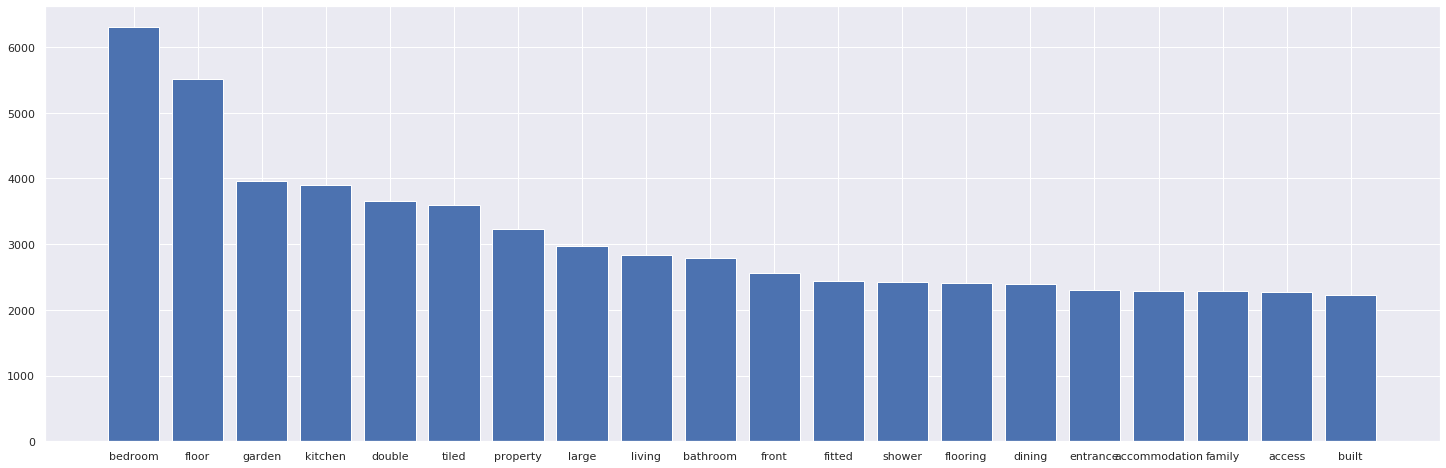

In [150]:
fig, ax = plt.subplots(figsize=(25, 8))
ax.bar(range(len(desc_top_20)), [t[1] for t in desc_top_20], align="center")
ax.set_xticks(range(len(desc_top_20)))
ax.set_xticklabels([t[0] for t in desc_top_20])

plt.show()

#### Display the most common words from `Features`.

In [151]:
feat_list = list(df_train_inc_nlp['Features'].values.flatten())
words = [word for item in feat_list for word in item.split()]
print("Total number of words {}".format(len(words)))

feat_top_20 = Counter(words).most_common(20)

Total number of words 26377


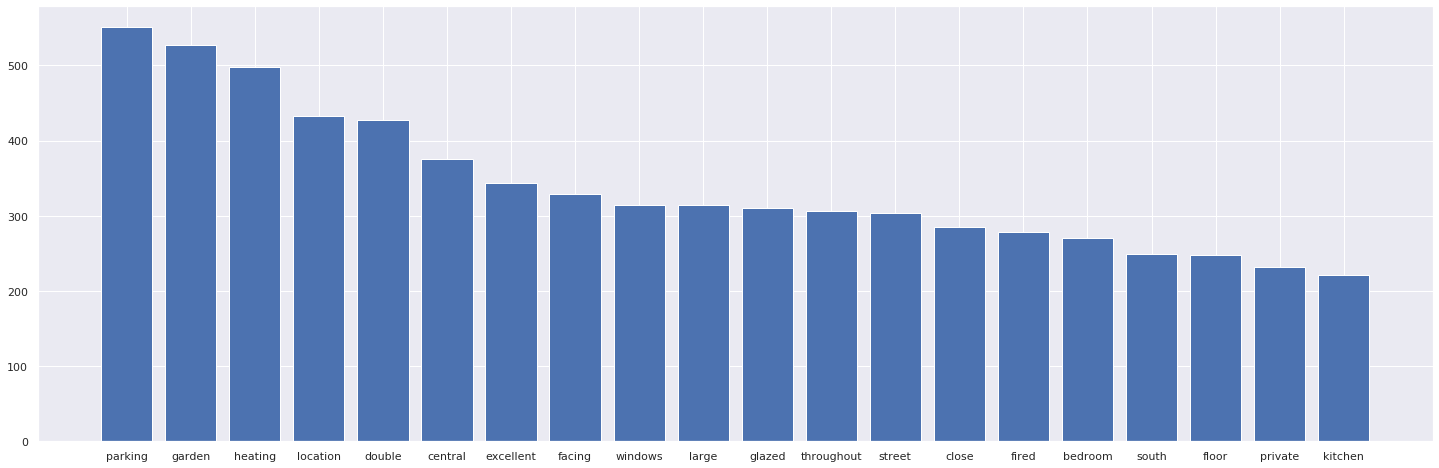

In [152]:
fig, ax = plt.subplots(figsize=(25, 8))
ax.bar(range(len(feat_top_20)), [t[1] for t in feat_top_20], align="center")
ax.set_xticks(range(len(feat_top_20)))
ax.set_xticklabels([t[0] for t in feat_top_20])

plt.show()

The above 2 plots only give a sample of the most common single words for each attribute type but they are not necessarily the most important/relevant. For example, 'double','living', 'excellent' or 'throughout' probably won't be of any use on their own and I would generally expect properties to have a kitchen. This is where TF-IDF might be useful.

### Splitting the data
The `df_train_inc_nlp` variable includes the text based features but since there is no `Price` in the test data, I have to use the training data, so I will split that into training and test datasets before applying any specific NLP technique to the data.

In [153]:
# Separating the predictor variable from the data set
X_nlp_data = df_train_inc_nlp.loc[:, df_train_inc_nlp.columns != 'Price']
y_nlp_data = df_train_inc_nlp['Price']

TfidfVectorizer - Convert a collection of raw documents to a matrix of **T**erm **F**requency-**I**nverse **D**ocument **F**requency features.
* How relevant a word is to a document in a collection of documents.

In [154]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=300, max_df=0.5, smooth_idf=True)
print(vectorizer)

TfidfVectorizer(max_df=0.5, max_features=300, stop_words='english')


Vectorising is only for the textual features and not the whole list of features in `df_train_nlp` or `X_train` etc.<br>
Function `get_feature_names` working as I am using 0.24 of sklearn.

In [155]:
# Learn vocabulary and idf, return document-term matrix.
Xtrain_loc_fit_nlp = vectorizer.fit_transform(X_nlp_data['Location'])
loc_feat_names = vectorizer.get_feature_names()

Xtrain_desc_fit_nlp = vectorizer.fit_transform(X_nlp_data['Description'])
desc_feat_names = vectorizer.get_feature_names()

Xtrain_feat_fit_nlp = vectorizer.fit_transform(X_nlp_data['Features'])
features_feat_names = vectorizer.get_feature_names()

print(Xtrain_loc_fit_nlp.shape)
print(Xtrain_desc_fit_nlp.shape)
print(Xtrain_feat_fit_nlp.shape)

(1637, 136)
(1637, 300)
(1637, 300)


## Train the model <a id='model_train'></a>
Testing with individual textual features only. The `nlp_train` method wll calculate training and prediction for passed NLP attributes.

In [156]:
y_loc_nlp_train, y_loc_nlp_test, y_loc_pred_train, y_loc_pred_test = nlp_train(Xtrain_loc_fit_nlp,
                                                                       y_nlp_data,
                                                                       train_test_percent)

y_desc_nlp_train, y_desc_nlp_test, y_desc_pred_train, y_desc_pred_test = nlp_train(Xtrain_desc_fit_nlp,
                                                                                y_nlp_data,
                                                                                train_test_percent)

y_feat_nlp_train, y_feat_nlp_test, y_feat_pred_train, y_feat_pred_test = nlp_train(Xtrain_feat_fit_nlp,
                                                                                y_nlp_data,
                                                                                train_test_percent)


## Accuracy <a id='accuracy'></a>
For the training set and testing set of all 3 text attributes.

In [157]:
# Accuracy in training and testing set of each text attribute
print("Location train Accuracy: {}".format(accuracy_score(y_loc_nlp_train, y_loc_pred_train)))
print("Location test Accuracy: {}\n".format(accuracy_score(y_loc_nlp_test, y_loc_pred_test)))

print("Description train Accuracy: {}".format(accuracy_score(y_desc_nlp_train, y_desc_pred_train)))
print("Description test Accuracy: {}\n".format(accuracy_score(y_desc_nlp_test, y_desc_pred_test)))

print("Features train Accuracy: {}".format(accuracy_score(y_feat_nlp_train, y_feat_pred_train)))
print("Features test Accuracy: {}".format(accuracy_score(y_feat_nlp_test, y_feat_pred_test)))

Location train Accuracy: 0.12406015037593984
Location test Accuracy: 0.03664921465968586

Description train Accuracy: 0.17105263157894737
Description test Accuracy: 0.034904013961605584

Features train Accuracy: 0.13815789473684212
Features test Accuracy: 0.02443280977312391


Get some idea of how the data was split.

In [158]:
print(features_feat_names)
print(len(features_feat_names))

['abundance', 'access', 'accommodation', 'acres', 'address', 'adjacent', 'airport', 'alarm', 'alarmed', 'amenities', 'ample', 'annum', 'apartment', 'appliances', 'approx', 'approximately', 'areas', 'aspect', 'attic', 'attractive', 'available', 'balconies', 'balcony', 'bathroom', 'bathrooms', 'beach', 'beautiful', 'beautifully', 'bedroom', 'bedrooms', 'bespoke', 'blackrock', 'blinds', 'block', 'boiler', 'brick', 'bright', 'built', 'bungalow', 'burglar', 'canal', 'carpets', 'castleknock', 'ceiling', 'ceilings', 'central', 'centre', 'charge', 'charming', 'choice', 'circa', 'clontarf', 'close', 'cobble', 'communal', 'company', 'condition', 'contemporary', 'convenient', 'conversion', 'converted', 'corner', 'courtyard', 'curtains', 'decorated', 'design', 'designated', 'designed', 'desirable', 'detached', 'development', 'dining', 'distance', 'doors', 'doorstep', 'double', 'downstairs', 'drive', 'driveway', 'dublin', 'dundrum', 'duplex', 'efficient', 'electric', 'electronic', 'energy', 'ensuit

# PIECEWISE REGRESSION <a id='piecewise_regression'></a>

**Piecewise regression**, extract from [Wikipedia](https://en.wikipedia.org/wiki/Segmented_regression):

Segmented regression, also known as piecewise regression or broken-stick regression, is a method in regression analysis in which the independent variable is partitioned into intervals and a separate line segment is fit to each interval. 

* Segmented regression analysis can also be performed on 
multivariate data by partitioning the various independent variables. 
* Segmented regression is useful when the independent variables, clustered into different groups, exhibit different relationships between the variables in these regions. 

* The boundaries between the segments are breakpoints.

* Segmented linear regression is segmented regression whereby the relations in the intervals are obtained by linear regression. 

For now, until I get more from the NLP, I will drop the 3 textual features listed above to get base from which to start/measure from. All other features at this stage should be converted or dropped.

In [159]:
X_nlp_data = df_train_inc_nlp.loc[:, df_train_inc_nlp.columns != 'Price']
y_nlp_data = df_train_inc_nlp['Price']

drop_nlp_features = ['Index', 'Description', 'Features']
df_train_clean = df_train_clean.drop(columns=drop_nlp_features)

# Drop same columns from the test data set
df_test_clean = df_test_clean.drop(columns=drop_nlp_features)

print("Features left in training dataset\n {}".format(list(df_train_clean.columns.values)))

Features left in training dataset
 ['Location', 'Num_Bathrooms', 'Num_Beds', 'BER_class', 'Latitude', 'Longitude', 'Type', 'Surface', 'Price']


#### Using RandomForest for feature importance selection
Suggestion from Carlos from etivity2

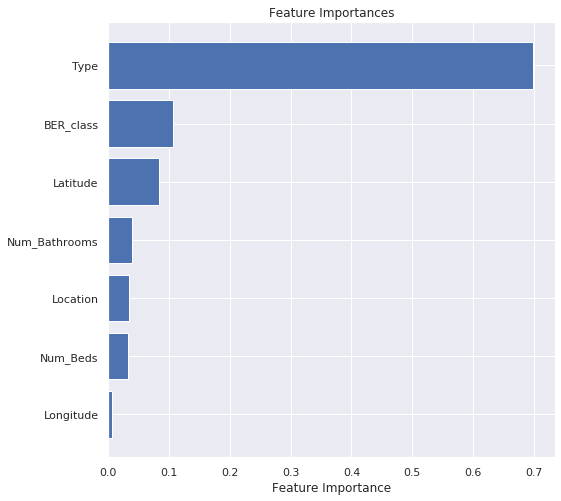

In [160]:
# Drop location as need numerical values
tmp_data = df_train_clean.drop('Location', axis=1).values
num_rows, num_cols = tmp_data.shape

model = RandomForestRegressor(random_state=8, max_depth=8)
X_orig = tmp_data[:,0:(num_cols -1)]
y_orig = tmp_data[:,(num_cols - 1)]
      
model.fit(X_orig, y_orig)

features = df_train_clean.drop('Price', axis=1).columns
importances = model.feature_importances_
indices = np.argsort(importances)[-10:]

sns.set(rc={'figure.figsize':(8,8)})
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Feature Importance')
plt.show()

#### Using ExtraTreesClassifier for feature importance selection
Using this as another method to compare to the above - a second opinion.

[0.06159382 0.06035562 0.14652602 0.22292902 0.22574785 0.06381948
 0.21902819]


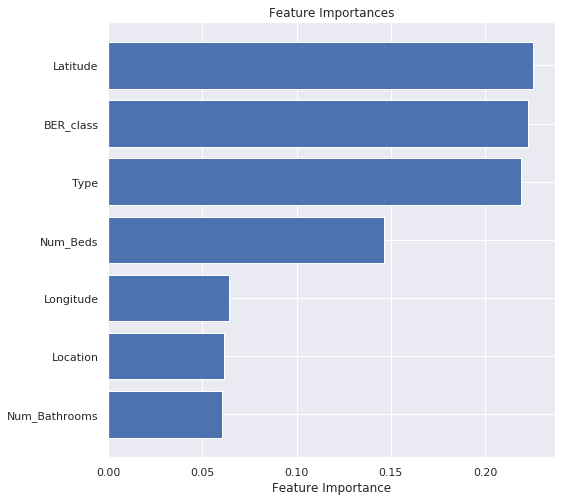

In [161]:
extra_tmp_data = df_train_clean.drop('Location', axis=1).values
num_rows, num_cols = extra_tmp_data.shape

X_orig = extra_tmp_data[:,0:(num_cols -1)]
y_orig = extra_tmp_data[:,(num_cols - 1)]

model = ExtraTreesClassifier(n_estimators=10)
model.fit(X_orig, y_orig)

print(model.feature_importances_)
features = df_train_clean.drop('Price', axis=1).columns
importances = model.feature_importances_
indices = np.argsort(importances)[-10:]

sns.set(rc={'figure.figsize':(8,8)})
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Feature Importance')
plt.show()

### Split the training data
* Since there is no separate price data provided, we are splitting the training data in to train and test datasets.

In [162]:
df_train_clean.head(2)

,Location,Num_Bathrooms,Num_Beds,BER_class,Latitude,Longitude,Type,Surface,Price
0,ongar,2,2,9.0,53.396659,-6.438791,1,67.00,195000
1,north strand,1,2,10.0,53.357129,-6.239779,5,95.97,425000


In [163]:
df_test_clean.head(2)

,Location,Num_Bathrooms,Num_Beds,BER_class,Latitude,Longitude,Type,Surface
0,milltown,2,2,8.0,53.316269,-6.243391,4,65.0
1,glasnevin,2,5,12.0,53.390769,-6.281936,7,142.0


In [164]:
# Select some features columns just for the baseline model that are numerical.
# Leave Price as last element for splitting
featrain = ['Num_Beds','Num_Bathrooms', 'Latitude','Longitude', 'BER_class', 'Type', 'Price']

# dropna: remove missing values. Drop Price as that is what we are trying to predict
df_subset_train = df_train_clean[featrain[:-1]].dropna(axis=0).values

# Test data - should be Price. This is a numpy.ndarray, so it will have shape of (x,1)
df_subset_test = df_train_clean[featrain[-1:]].dropna(axis=0).values

# This is a series, I.E a single array, so it will be (x,). will have same values as df_subset_test
df_price = df_train_clean['Price'].values

X_total_test = df_test_clean[featrain[:-1]].iloc[:,0:].values

Split the data into training & test sets and validation sets for both.

In [165]:

Xs_train, Xs_test, ys_train, y_test = train_test_split(df_subset_train,
                                                    df_price, #df_subset_test,
                                                    test_size=train_test_percent)


## Apply a full model <a id='apply_full_model'></a>
Now apply all of the features you are going to use to see how they perform together.

In [166]:
# StandardScaler() will normalize the features i.e. each column of X, 
# so, each column/feature/variable will have μ = 0 and σ = 1
sc = StandardScaler()

# hstack will concatenation along the second axis
# Training from train_test_split()
Xss_train = np.hstack([Xs_train, Xs_train[:,[2]]**2])
xscaler = sc.fit(Xss_train)
Xn_train = xscaler.transform(Xss_train)

Xss_test = np.hstack([Xs_test, Xs_test[:,[2]]**2])
Xn_test = xscaler.transform(Xss_test)

Xss_total_test = np.hstack([X_total_test, X_total_test[:,[2]]**2])
Xn_total_test = xscaler.transform(Xss_total_test)

ylog = np.log(ys_train.astype('float').reshape(-1,1))
yscaler = sc.fit(ylog)
yn_train = yscaler.transform(ylog)


#### Run the model and display

Finished [100%]: Average Loss = 1,081.3


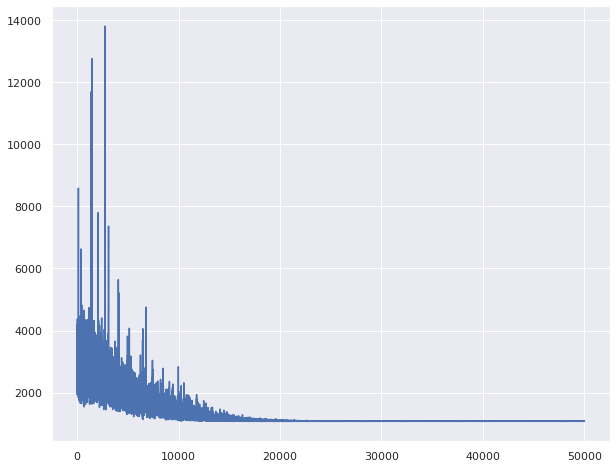

In [167]:
full_posterior, full_approximation = run_model(Xn_train, yn_train, num_iter, sample_size)

plt.figure(figsize=(10, 8))
plt.plot(full_approximation.hist);

`Xn_test` is not the full 702 that is required so can't use that for the Kaggle csv file. `Xn_total_test` is the full 702.

In [168]:
# prediction
ll=np.mean(full_posterior['alpha']) + np.dot(np.mean(full_posterior['beta'],axis=0), Xn_test.T)
y_pred_BLR = np.exp(yscaler.inverse_transform(ll.reshape(-1,1)))[:,0]

full_model_mae = np.mean(abs(y_pred_BLR - y_test))
full_model_mape = np.mean(abs(y_pred_BLR - y_test) / y_test)

print("Full model prediction")
print("MAE = {}".format(full_model_mae))
print("MAPE = {}".format(full_model_mape))

Full model prediction
MAE = 179980.00584378402
MAPE = 0.31742353736971085


The above error scores seem to generally perform much better when using the array `df_price` versus the numpy array `df_subset_test`, even though they both contain the same values in the same order. Even with that, I have seen it fluctuate by a large amount from < ~180k to over 400k.

#### Save to file for Kaggle

In [169]:
print(Xn_total_test.shape)
ll=np.mean(full_posterior['alpha']) + np.dot(np.mean(full_posterior['beta'],axis=0), Xn_total_test.T)
y_pred_BLR = np.exp(yscaler.inverse_transform(ll.reshape(-1,1)))[:,0]


kaggle_price = pd.DataFrame(y_pred_BLR, columns=['Price'])
test_predictions = pd.concat([df_test_data['Index'], kaggle_price.astype(int)], axis=1)
test_predictions.to_csv(Path + 'ET5003_Kaggle_Team6.csv', index=False)

(702, 7)


## Clustering <a id='clustering'></a>
In this section we will break the full dataset into smaller clusters based on features to see if they can reduce the overall MAE value seen above.

### Full Model Cluster <a id='full_model_cluster'></a>

In [170]:
# Training gaussian mixture model. Must equal the number of features I chose
gmm = GaussianMixture(n_components=6)

# clustering by features long & lat
ind=[2,3]
X_ind = np.vstack([Xn_train[:,ind], Xn_total_test[:,ind]])

# Gaussian Mixture
gmm.fit(X_ind)

GaussianMixture(n_components=6)

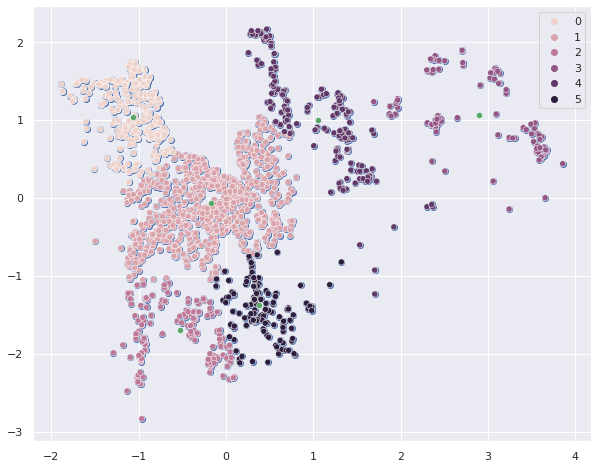

In [171]:
# Plot features used and centroids of those features
plt.figure(figsize=(10, 8))
plt.scatter(X_ind[:,0],X_ind[:,1])
labels = gmm.fit_predict(X_ind)

sns.scatterplot(x=X_ind[:,0], y=X_ind[:,1], hue=gmm.fit_predict(X_ind))
sns.scatterplot(x=gmm.means_[:,0], y=gmm.means_[:,1])#, size=gmm.means_[:,1], sizes=(150, 150))

In [172]:
np.max(ys_train)

8900000

## Cluster setup <a id='cluster_setup'></a>
Now setup the training and testing clusters.

#### Training clusters

In [173]:
# train clusters
clusters_train = gmm.predict(Xn_train[:,ind])
unique_train, counts_train = np.unique(clusters_train, return_counts=True)
dict(zip(unique_train, counts_train))

print("{} {}".format(unique_train, counts_train))

[0 1 2 3 4 5] [165 528 109  58 117  87]


#### Testing clusters

In [174]:
# test clusters
clusters_test = gmm.predict(Xn_total_test[:,ind])
unique_test, counts_test = np.unique(clusters_test, return_counts=True)
dict(zip(unique_test, counts_test))

print("{} {}".format(unique_test, counts_test))

[0 1 2 3 4 5] [116 360  55  40  72  59]


## Simulations and Piecewise Model <a id='simulations'></a>

Running piecewise regression on a number of clusters to see if they produce a better outcome than the full single model above.

#### Cluster 0

Finished [100%]: Average Loss = 216.13


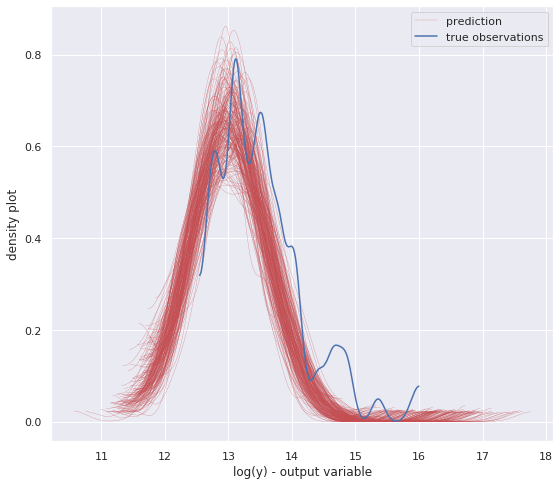

In [175]:
ylog0, Xn0, yn0, Xtestn0, yscaler0 = train_cluster(Xn_train, Xn_total_test, ys_train.reshape(-1,1), 0)
cl0_posterior, cl0_approximation = run_model(Xn0, yn0, num_iter, sample_size)
cluster_sim(cl0_posterior, Xn0, ylog0, num_samples=num_of_clust_samples)

Finished [100%]: Average Loss = 216.13


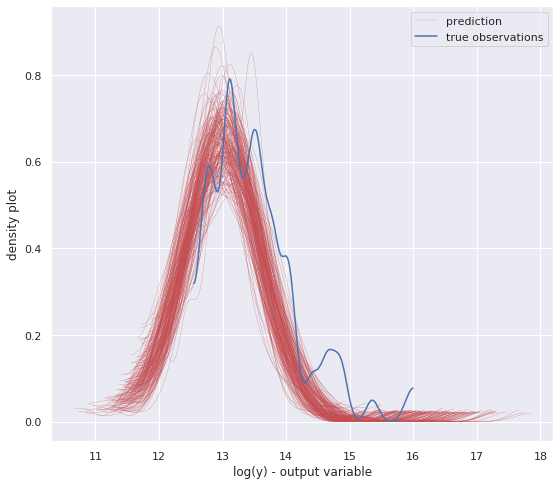

In [176]:
ylog0, Xn0, yn0, Xtestn0, yscaler0 = train_cluster(Xn_train, Xn_total_test, ys_train.reshape(-1,1), 0)
cl0_posterior, cl0_approximation = run_model(Xn0, yn0, num_iter, sample_size)
cluster_sim(cl0_posterior, Xn0, ylog0, num_samples=num_of_clust_samples)

#### Cluster 1

Finished [100%]: Average Loss = 554.4


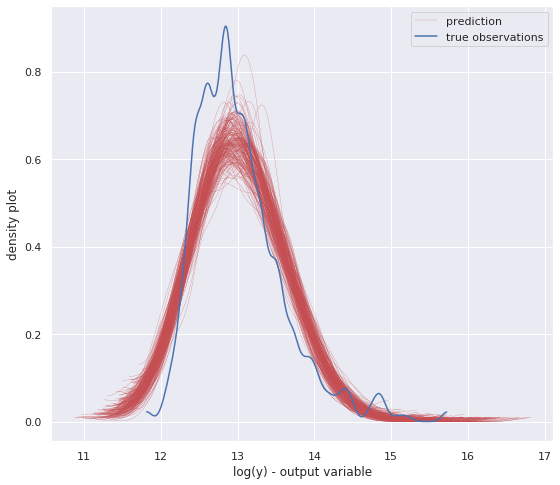

In [177]:
ylog1, Xn1, yn1, Xtestn1, yscaler1 = train_cluster(Xn_train, Xn_total_test, ys_train.reshape(-1,1), 1)
cl1_posterior, cl1_approximation = run_model(Xn1, yn1, num_iter, sample_size)
cluster_sim(cl1_posterior, Xn1, ylog1, num_samples=num_of_clust_samples)

#### Cluster 2

Finished [100%]: Average Loss = 147.32


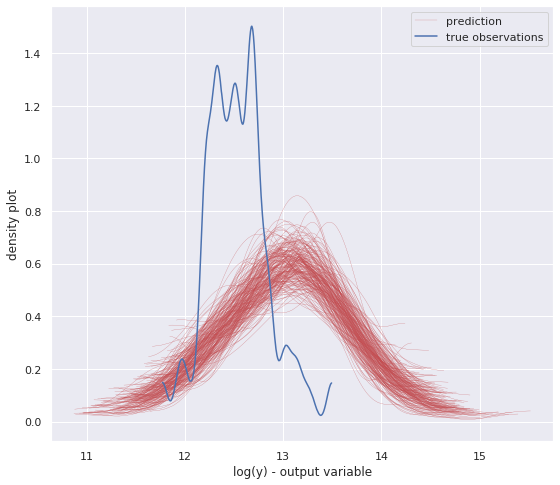

In [178]:
ylog2, Xn2, yn2, Xtestn2, yscaler2 = train_cluster(Xn_train, Xn_total_test, ys_train.reshape(-1,1), 2)
cl2_posterior, cl2_approximation = run_model(Xn2, yn2, num_iter, sample_size)
cluster_sim(cl2_posterior, Xn2, ylog2, num_samples=num_of_clust_samples)

#### Cluster 3

Finished [100%]: Average Loss = 111.78


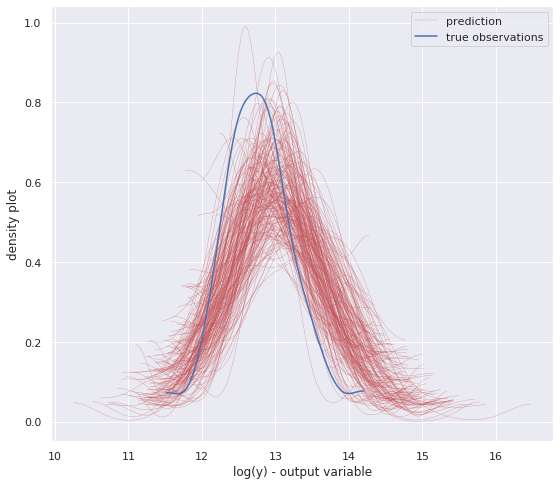

In [179]:
ylog3, Xn3, yn3, Xtestn3, yscaler3 = train_cluster(Xn_train, Xn_total_test, ys_train.reshape(-1,1), 3)
cl3_posterior, cl3_approximation = run_model(Xn3, yn3, num_iter, sample_size)
cluster_sim(cl3_posterior, Xn3, ylog3, num_samples=num_of_clust_samples)

#### Cluster 4

Finished [100%]: Average Loss = 157.51


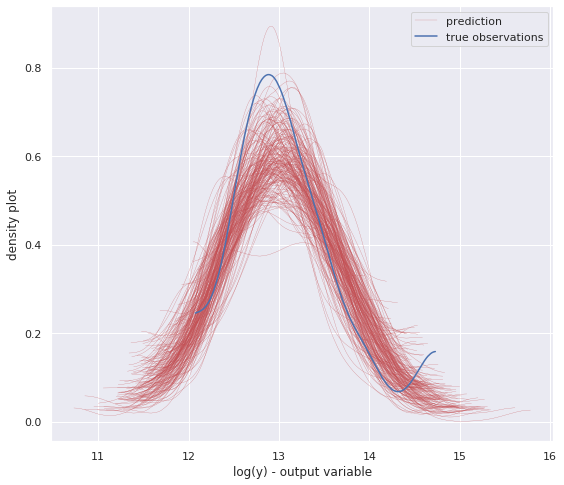

In [180]:
ylog4, Xn4, yn4, Xtestn4, yscaler4 = train_cluster(Xn_train, Xn_total_test, ys_train.reshape(-1,1), 4)
cl4_posterior, cl4_approximation = run_model(Xn4, yn4, num_iter, sample_size)
cluster_sim(cl4_posterior, Xn4, ylog4, num_samples=num_of_clust_samples)

#### Cluster 5

Finished [100%]: Average Loss = 111.02


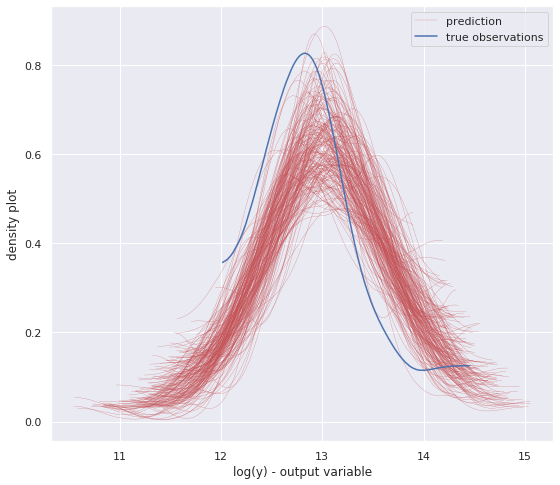

In [181]:
ylog5, Xn5, yn5, Xtestn5, yscaler5 = train_cluster(Xn_train, Xn_total_test, ys_train.reshape(-1,1), 5)
cl5_posterior, cl5_approximation = run_model(Xn5, yn5, num_iter, sample_size)
cluster_sim(cl5_posterior, Xn5, ylog5, num_samples=num_of_clust_samples)

### Overall

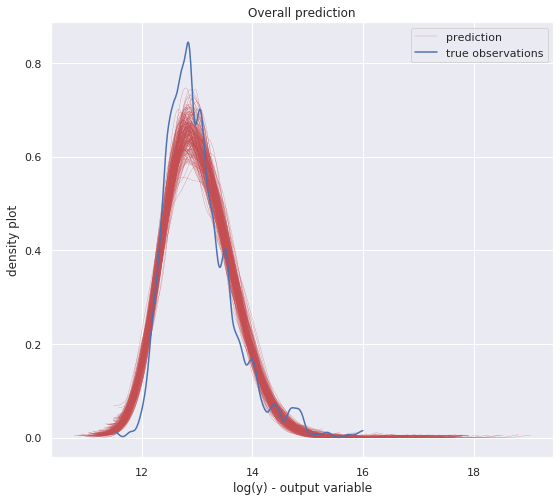

In [182]:
# posteriors
Ypred0 = ppc(cl0_posterior['alpha'], cl0_posterior['beta'], cl0_posterior['sigma_n'],
             Xn0, nsamples=num_of_clust_samples)
Ypred1 = ppc(cl1_posterior['alpha'], cl1_posterior['beta'], cl1_posterior['sigma_n'],
             Xn1, nsamples=num_of_clust_samples)
Ypred2 = ppc(cl2_posterior['alpha'], cl2_posterior['beta'], cl2_posterior['sigma_n'],
             Xn2, nsamples=num_of_clust_samples)
Ypred3 = ppc(cl3_posterior['alpha'], cl3_posterior['beta'], cl3_posterior['sigma_n'],
             Xn3, nsamples=num_of_clust_samples)
Ypred4 = ppc(cl4_posterior['alpha'], cl4_posterior['beta'], cl4_posterior['sigma_n'],
             Xn4, nsamples=num_of_clust_samples)
Ypred5 = ppc(cl5_posterior['alpha'], cl5_posterior['beta'], cl5_posterior['sigma_n'],
             Xn5, nsamples=num_of_clust_samples)

# simulation
Ypred = np.hstack([yscaler0.inverse_transform(Ypred0),
                 yscaler1.inverse_transform(Ypred1),
                 yscaler2.inverse_transform(Ypred2),
                 yscaler3.inverse_transform(Ypred3),
                 yscaler4.inverse_transform(Ypred4),
                 yscaler5.inverse_transform(Ypred5)])

ylog=np.vstack([ylog0, ylog1, ylog2, ylog3, ylog4, ylog5])
plot_redictions(Ypred, ylog, "Overall prediction")


## Test set performance <a id='test_set_perf'></a>
Evaluate the performance against the test set

In [186]:
# Cluster 0
y_pred_BLR0 = np.exp(yscaler0.inverse_transform(np.mean(cl0_posterior['alpha']) 
              + np.dot(np.mean(cl0_posterior['beta'],axis=0), Xtestn0.T)))

print(y_pred_BLR0.shape)
print(y_test.shape)

#print("Cluster 0 size is {} MAE = {}".format(np.sum(clusters_test==0),
#    (np.mean(abs(y_pred_BLR0 - y_test[clusters_test==0]))) ))

# Cluster 1
y_pred_BLR1 = np.exp(yscaler1.inverse_transform(np.mean(cl1_posterior['alpha']) 
              + np.dot(np.mean(cl1_posterior['beta'],axis=0), Xtestn1.T)))

#print("Cluster 1 size is {} MAE = {}".format(np.sum(clusters_test==1),
#    (np.mean(abs(y_pred_BLR1 - y_test[clusters_test==1]))) ))

# Cluster 2
y_pred_BLR2 = np.exp(yscaler2.inverse_transform(np.mean(cl2_posterior['alpha']) 
              + np.dot(np.mean(cl2_posterior['beta'],axis=0), Xtestn2.T)))

#print("Cluster 0 size is {} MAE = {}".format(np.sum(clusters_test==2),
#    (np.mean(abs(y_pred_BLR2 - y_test[clusters_test==2]))) ))

# Cluster 3
y_pred_BLR3 = np.exp(yscaler3.inverse_transform(np.mean(cl3_posterior['alpha']) 
              + np.dot(np.mean(cl3_posterior['beta'],axis=0), Xtestn3.T)))

#print("Cluster 0 size is {} MAE = {}".format(np.sum(clusters_test==3),
#    (np.mean(abs(y_pred_BLR3 - y_test[clusters_test==3]))) ))

# Cluster 4
y_pred_BLR4 = np.exp(yscaler4.inverse_transform(np.mean(cl4_posterior['alpha']) 
              + np.dot(np.mean(cl4_posterior['beta'],axis=0), Xtestn4.T)))

#print("Cluster 0 size is {} MAE = {}".format(np.sum(clusters_test==4),
#    (np.mean(abs(y_pred_BLR4 - y_test[clusters_test==4]))) ))

# Cluster 5
y_pred_BLR5 = np.exp(yscaler5.inverse_transform(np.mean(cl5_posterior['alpha']) 
              + np.dot(np.mean(cl5_posterior['beta'],axis=0), Xtestn5.T)))

#print("Cluster 0 size is {} MAE = {}".format(np.sum(clusters_test==5),
#    (np.mean(abs(y_pred_BLR5 - y_test[clusters_test==5]))) ))

clustered_y_pred_BLR = np.hstack([y_pred_BLR0,
                                  y_pred_BLR1,
                                  y_pred_BLR2,
                                  y_pred_BLR3,
                                  y_pred_BLR4,
                                  y_pred_BLR5])

(116,)
(573,)


In [187]:
clust_kaggle_price = pd.DataFrame(clustered_y_pred_BLR, columns=['Price'])
test_predictions = pd.concat([df_test_data['Index'], clust_kaggle_price.astype(int)], axis=1)
test_predictions.to_csv(Path + 'ET5003_Cluster_Kaggle_Team6.csv', index=False)

# BAYESIAN Neural Network <a id='bayesian_nn'></a>

A [Bayesian network](https://en.wikipedia.org/wiki/Bayesian_network) (also known as a Bayes network, Bayes net, belief network, or decision network) is a probabilistic graphical model that represents a set of variables and their conditional dependencies via a directed acyclic graph (DAG). 

* Bayesian networks are ideal for taking an event that occurred and predicting the likelihood that any one of several possible known causes was the contributing factor. 
* For example, a Bayesian network could represent the probabilistic relationships between diseases and symptoms. 
* Given symptoms, the network can be used to compute the probabilities of the presence of various diseases.

BNN's are Stochastic artificial neural networks trained using Bayesian methods. A stochastic NN is built by introducing randon variables into the network. This is generally done by using random activation functions or weights. This will allow you to simulate multiple possible models, so you can get a group (ensemble) of outcomes/learning. The reason for simulating multiple models is to be able to combine the predictions of the various models instead of 1 possibly better predicting model.
The main goal of SNN is to get a better idea of the uncertainty ([Laurent_et_al](#Laurent_et_al), 2021)

### Create the model

In [188]:
# Seems to be somthing wrong with Xn_train
print(Xn_train.shape)
print("Xn_train [0] shape {}".format(Xn_train.shape[0]))
print("Xn_train [1] shape {}".format(Xn_train.shape[1]))

(1064, 7)
Xn_train [0] shape 1064
Xn_train [1] shape 7


Below is generating an error:
* `Input dimension mis-match. (input[0].shape[1] = 1, input[1].shape[1] = xxx)`
* I've tried it in Colab in Chrome as Colab won't upload files in Firefox but got the same shape error in that hosted environment, so not related to my local environment or difference in packages. Earlier issues were but were resolved when I downgraded sklean from 1.0 to 0.24.

In [ ]:
# https://theano-pymc.readthedocs.io/en/latest/
import theano

# Add a column of ones to include an intercept in the model
#x1 = np.vstack([np.ones(len(Xn_train)), Xn_train]).T
x1 = np.hstack([np.ones((Xn_train.shape[0],1)), Xn_train])

print("x1 shape {}".format(x1.shape))
print("x1 {}".format(x1))

floatX = theano.config.floatX

l = 15

# Initialize random weights between each layer
# we do that to help the numerical algorithm that computes the posterior
init_1 = np.random.randn(x1.shape[1], l).astype(floatX)
init_out = np.random.randn(l).astype(floatX)


# pymc3 model as neural_network
with pm.Model() as neural_network:
    
    # we convert the data in theano type so we can do dot products with the correct type.
    ann_input = pm.Data('ann_input', x1)
    ann_output = pm.Data('ann_output', yn_train)
    
    # Priors 
    # Weights from input to hidden layer
    weights_in_1 = pm.Normal('w_1',
                             0,
                             sigma=1,
                             shape=(x1.shape[1], l),
                             testval=init_1)
    
    # Weights from hidden layer to output
    weights_2_out = pm.Normal('w_0',
                              0,
                              sigma=1,
                              shape=(l,),
                              testval=init_out)

    # Build neural-network using tanh activation function
    # Inner layer
    act_1 = pm.math.tanh(pm.math.dot(ann_input, weights_in_1))
    
    # Linear layer, like in Linear regression
    act_out = pm.Deterministic('act_out',pm.math.dot(act_1, weights_2_out))
    
    # standard deviation of noise
    sigma = pm.HalfCauchy('sigma',5)
    
    print("ann_input {}".format(ann_input))
    print("Act out {}".format(act_out))
    print(sigma.shape)
    print(ann_output.shape)

    # Error here - Input dimension mis-match. (input[0].shape[1] = 1, input[1].shape[1] = xxx)
    # Normal likelihood
    out = pm.Normal('out',
                       act_out,
                       sigma=sigma,
                       observed=ann_output)

The error has been removed from this notebook to make it more readable.

In [190]:
# this can be slow because there are many parameters

# some parameters
par1 = 50  # start with 100, then use 1000+
par2 = 500 # start with 1000, then use 10000+

# neural network
with neural_network:
    bnn_posterior = pm.sample(par1, tune=par2, chains=1)

Only 50 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, w_0, w_1]


Sampling 1 chain for 500 tune and 50 draw iterations (500 + 50 draws total) took 2 seconds.


In [191]:
# we can do instead an approximated inference
param3 = 100000 # start with 1000, then use 50000+
VI = 'advi'  # 'advi', 'fullrank_advi', 'svgd', 'asvgd', 'nfvi'
OP = pm.adam # pm.adam, pm.sgd, pm.adagrad, pm.adagrad_window, pm.adadelta
LR = 0.0001    

with neural_network:
    approx = pm.fit(param3, method=VI, obj_optimizer=pm.adam(learning_rate=LR))

Finished [100%]: Average Loss = 0.029737


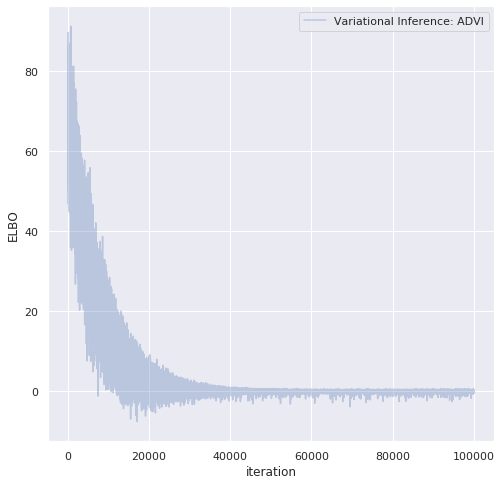

In [192]:
# plot 
pb.plot(approx.hist, label='Variational Inference: '+ VI.upper(), alpha=.3)
pb.legend(loc='upper right')

# Evidence Lower Bound (ELBO)
# https://en.wikipedia.org/wiki/Evidence_lower_bound
pb.ylabel('ELBO')
pb.xlabel('iteration');

#### Choose samples on which to evaluate the model

In [193]:
# draw samples from variational posterior
bnn_posterior = approx.sample(draws=sample_size)

Now, we compute the prediction for each sample. 
* Note that we use `np.tanh` instead of `pm.math.tanh`
for speed reason. 
* `pm.math.tanh` is slower outside a Pymc3 model because it converts all data in theano format.
* It is convenient to do GPU-based training, but it is slow when we only need to compute predictions.

### Evaluate the model
* Using the test set to do this

In [194]:
# Add a column of ones to include an intercept in the model
x2 = np.hstack([np.ones((Xn_test.shape[0],1)), Xn_test])

bnn_y_pred = []
for i in range(bnn_posterior['w_1'].shape[0]):
    
    #inner layer
    t1 = np.tanh(np.dot(bnn_posterior['w_1'][i,:,:].T,x2.T))
    
    #outer layer
    bnn_y_pred.append(np.dot(bnn_posterior['w_0'][i,:],t1))

# predictions   
bnn_y_pred = np.array(bnn_y_pred)

The values below are far worse than what was calculated for Piecewise and this is probably related to the error I have outlined above when creating the model.

In [195]:
y_val_pred_final = np.exp(yscaler.inverse_transform(bnn_y_pred))

print(bnn_y_pred.shape)
print(y_val_pred_final.shape)
print(y_test.shape)

print("MAE = ",(np.mean(abs(y_val_pred_final - y_test))))
print("MAPE = ",(np.mean(abs(y_val_pred_final - y_test) / y_test)))

(5000, 573)
(5000, 573)
(573,)
MAE =  3154491.985060289
MAPE =  8.958255786659233


#### Final prediction
* Try to predict the final set of index & price data for the competition and then write those to a file.

In [196]:
# add a column of ones to include an intercept in the model
x2 = np.hstack([np.ones((Xn_total_test.shape[0],1)), Xn_total_test])

bnn_y_pred = []
for i in range(bnn_posterior['w_1'].shape[0]):

    # Inner layer
    t1 = np.tanh(np.dot(bnn_posterior['w_1'][i,:,:].T,x2.T))
    
    # Outer layer
    bnn_y_pred.append(np.dot(bnn_posterior['w_0'][i,:],t1))

# predictions   
bnn_y_pred = np.array(bnn_y_pred).mean(axis=0)
bnn_y_pred_final = np.exp(yscaler.inverse_transform(bnn_y_pred))

In [197]:
bnn_kaggle_price = pd.DataFrame(bnn_y_pred_final, columns=['Price'])
test_predictions = pd.concat([df_test_data['Index'], bnn_kaggle_price.astype(int)], axis=1)
test_predictions.to_csv(Path + 'ET5003_BayesianNN_Kaggle_Team6.csv', index=False)

# SUMMARY

### Basic understanding
Building on the previous etivities, I attempted to use features of NLP libraries to locate other features that may improve the performance of the model when predicting house prices for the given dataset. I then compared that to the output from Piecewise regression and would have compared that to my BayesianNN attempt, had I resolved the issue.

#### General
For the [nlp_processing](#nlp_processing) section, I first examined the top 20 list of single words in each of the 2 main categorical sections - `Description` and `Features`.
In [piecewise_regression](#piecewise_regression) I selected a subset of the features that after several tests seem to produce the best resutls.
For the [bayesian_nn](#bayesian_nn) section I was attempting to compare that to the results of the other sections but the error I highlighted above prevented any meaningful comparision.

#### Peer Contribution
From the members who directly commented on what I had submitted - Mike, Nigel & Kenneth - to the meetings we had in Team 6 and the other posts in relation to what to select from NLP features and the general discussion around the resulting performance that people were seeing - all of those contributions across all the groups has been invaluable **especially** on this assignment.

### References
#### Websites
<a id='AI-1'></a>https://becominghuman.ai/nlp-with-real-estate-advertisements-part-2-f944e566644b<br>
<a id='AI-2'></a>https://becominghuman.ai/nlp-with-real-estate-advertisements-part-1-55200e0cb33c<br>
http://spacy.pythonhumanities.com/01_02_linguistic_annotations.html<br>
https://www.einfochips.com/blog/nlp-text-vectorization/<br>
https://www.analyticsvidhya.com/blog/2021/06/part-5-step-by-step-guide-to-master-nlp-text-vectorization-approaches/<br>
https://www.statisticshowto.com/mean-absolute-percentage-error-mape/

#### Books/Papers
* <a id='Laurent_et_al'></a> Laurent Valentin Jospin, Hamid Laga, Farid Boussaid, Wray Buntine, Mohammed Bennamoun, "Hands-on Bayesian Neural Networks – a Tutorial for Deep Learning Users" September 2021 https://arxiv.org/pdf/2007.06823.pdf